In [1]:
pip install yfinance


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import yfinance as yf

In [3]:
sp500 = yf.Ticker('^GSPC')

In [4]:
sp500 = sp500.history(period='max')

^GSPC: No price data found, symbol may be delisted (1d 1924-08-16 -> 2023-07-24)


In [5]:
sp500

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [6]:
sp500.index

Index([], dtype='object', name='Date')

<AxesSubplot:xlabel='Date'>

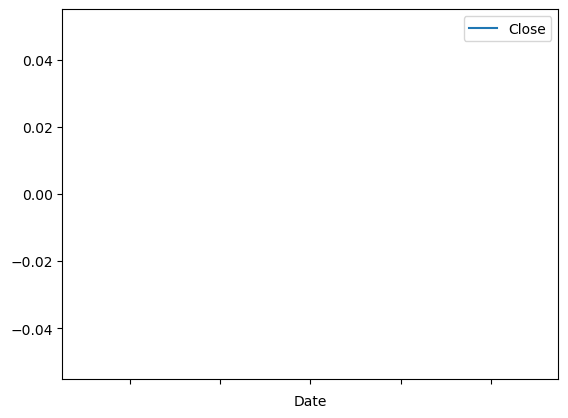

In [7]:
sp500.plot.line(y='Close',use_index=True)

In [8]:
del sp500['Dividends']

KeyError: 'Dividends'

In [ ]:
del sp500['Stock Splits']

In [ ]:
sp500['Tommorow'] = sp500['Close'].shift(-1)

In [ ]:
sp500

In [ ]:
sp500['Target'] = (sp500['Tommorow'] > sp500['Close']).astype(int)

In [ ]:
sp500

In [ ]:
sp500 = sp500.loc['1990-01-01':].copy()

In [ ]:
sp500

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier(n_estimators=100,min_samples_split=100,random_state=1)

In [ ]:
train = sp500.iloc[:-100]

In [ ]:
test = sp500.iloc[-100:]

In [ ]:
predictors = ['Close', 'Volume', 'Open', 'High', 'Low']

In [ ]:
model.fit(train[predictors],train['Target'])

In [ ]:
from sklearn.metrics import precision_score

In [ ]:
pred = model.predict(test[predictors])

In [ ]:
import pandas as pd

In [ ]:
pred = pd.Series(pred, index=test.index)

In [ ]:
pred

In [ ]:
precision_score(test['Target'],pred)

In [ ]:
combined = pd.concat([test['Target'], pred], axis=1)

In [ ]:
combined.plot()

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors],train['Target'])
    pred = model.predict(test[predictors])
    pred = pd.Series(pred, index=test.index, name='Predictions')
    combined = pd.concat([test['Target'], pred], axis=1)
    return combined

In [ ]:
def backtest(data, model, predictors, start=2500, step=250):
    all_pred=[]
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_pred.append(predictions)
    return pd.concat(all_pred)

In [ ]:
predictions = backtest(sp500, model, predictors)

In [ ]:
predictions['Predictions'].value_counts()

In [ ]:
predictions

In [ ]:
precision_score(predictions['Target'],predictions['Predictions'])

In [ ]:
horizons = [2,5,60,1000]
new_predictors = []

for horizon in horizons:
    rolling_avg = sp500.rolling(horizon).mean()
    
    ratio_col = f"Close_ratio_{horizon}"
    sp500[ratio_col] = sp500['Close']/rolling_avg['Close']
    
    trend_col = f"Trend_{horizon}"
    sp500[trend_col] = sp500.shift(1).rolling(horizon).sum()['Target']
    
    new_predictors += [ratio_col, trend_col]

In [ ]:
sp500 = sp500.dropna()

In [ ]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors],train['Target'])
    pred = model.predict_proba(test[predictors])[:,1]
    pred[pred>=.6] = 1
    pred[pred<.6] = 0
    pred = pd.Series(pred, index=test.index, name='Predictions')
    combined = pd.concat([test['Target'], pred], axis=1)
    return combined

In [ ]:
predictions = backtest(sp500, model, new_predictors)

In [ ]:
predictions['Predictions'].value_counts()

In [ ]:
precision_score(predictions["Target"],predictions['Predictions'])